In [ ]:
import pandas as pd
from google.colab import files
from google.colab import drive
data = pd.read_csv('/content/cleaned_electricity_data (1).csv', header=0)

In [ ]:
df = pd.DataFrame(data)

In [ ]:
print(df)

                                CONS_NO  FLAG  2014/1/1  2014/1/10  2014/1/11  \
0      0387DD8A07E07FDA6271170F86AD9151     1      0.00       0.00       0.00   
1      01D6177B5D4FFE0CABA9EF17DAFC2B84     1      0.00       0.00       0.00   
2      4B75AC4F2D8434CFF62DB64D0BB43103     1      0.00       0.00       0.00   
3      B32AC8CC6D5D805AC053557AB05F5343     1      0.00       0.00       0.00   
4      EDFC78B07BA2908B3395C4EB2304665E     1      2.90       3.42       3.81   
...                                 ...   ...       ...        ...        ...   
12671  5EB20B04844180A052ADA4D1604593E0     0     14.98       6.88       5.51   
12672  A8A0750778A7E4B333408855D00E62DD     0      7.98       5.40       5.15   
12673  9176C50371B806808E49376FA993C702     0      0.00       0.00       0.00   
12674  43A71280BE4BDE116B2A80DF38297571     0      0.00       0.00       0.00   
12675  2A3C58D6154EC8ECD188E40EAA4CFB75     0      0.00       0.01       0.00   

       2014/1/12  2014/1/13

In [ ]:
# checking the distribution for normal and theft
class_distribution = data['FLAG'].value_counts()

print("Class Distribution (Raw Counts):")
print(class_distribution)

distribution_percentage = (class_distribution / len(data)) * 100

print("\nClass Distribution (Percentages):")
print(distribution_percentage)

Class Distribution (Raw Counts):
FLAG
0    9064
1    3612
Name: count, dtype: int64

Class Distribution (Percentages):
FLAG
0    71.505207
1    28.494793
Name: count, dtype: float64


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
consumption_columns = [col for col in data.columns if '/' in col]

In [ ]:
X = data.drop(columns=['FLAG', 'CONS_NO'])
y = data['FLAG']

In [ ]:
X = X.dropna()
y = y[X.index]

In [ ]:
X = X.fillna(X.mean()) #filled nan value with mean

In [ ]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

In [ ]:
from imblearn.over_sampling import SMOTE

#Applying SMOTE
smote = SMOTE(sampling_strategy=1.0, random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y)


print("Balanced Class Distribution:")
print(pd.Series(y_balanced).value_counts())


Balanced Class Distribution:
FLAG
1    9063
0    9063
Name: count, dtype: int64


In [ ]:
X_normal = X_balanced[y_balanced == 0]
y_normal = y_balanced[y_balanced == 0]

print("Shape of normal data (FLAG = 0):", X_normal.shape)

Shape of normal data (FLAG = 0): (9063, 1035)


In [ ]:
from sklearn.svm import OneClassSVM

In [ ]:
novelty_detector = OneClassSVM(kernel='rbf', nu=0.1, gamma='auto')

In [ ]:
novelty_detector.fit(X_normal)

OneClassSVM(gamma='auto', nu=0.1)

In [ ]:
print("Novelty detection model trained on normal FLAG = 0 samples.")

Novelty detection model trained on normal FLAG = 0 samples.


In [ ]:
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Step 2: Prepare a mixed dataset for testing (containing both FLAG = 0 and FLAG = 1)
X_test_mixed = X_balanced.copy()  # Copy the original balanced dataset for testing
y_test_mixed = y_balanced.copy()

In [ ]:
np.random.seed(42)
num_anomalies = int(0.05 * len(X_test_mixed))
anomaly_indices = np.random.choice(X_test_mixed.index, num_anomalies, replace=False)

In [ ]:
feature_name = 'total_consumption'  # Adjust to the actual feature name in your dataset
X_test_mixed.loc[anomaly_indices, feature_name] = X_test_mixed[feature_name].max() * 10  # Increase values by a factor to simulate anomalies

In [ ]:
# Update the true labels for these anomalies
y_test_mixed.loc[anomaly_indices] = 1  # Set these samples to FLAG = 1 (anomaly)

In [ ]:
 #Step 4: Use the novelty detection model to predict anomalies in the mixed dataset
y_pred = novelty_detector.predict(X_test_mixed)

In [ ]:
# Map One-Class SVM predictions to match original labels: 1 (inliers) to 0 (normal) and -1 (outliers) to 1 (anomalies)
y_pred = [0 if label == 1 else 1 for label in y_pred]


In [ ]:
# Step 5: Evaluate the model's performance on the mixed dataset
print("Classification Report:\n", classification_report(y_test_mixed, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test_mixed, y_pred))
print("Accuracy:", accuracy_score(y_test_mixed, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.49      0.63      8576
           1       0.67      0.94      0.78      9550

    accuracy                           0.72     18126
   macro avg       0.77      0.71      0.70     18126
weighted avg       0.77      0.72      0.71     18126

Confusion Matrix:
 [[4181 4395]
 [ 594 8956]]
Accuracy: 0.7247600132406488


Available features: Index(['2014/1/1', '2014/1/10', '2014/1/11', '2014/1/12', '2014/1/13',
       '2014/1/14', '2014/1/15', '2014/1/16', '2014/1/17', '2014/1/18',
       ...
       '2016/9/29', '2016/9/3', '2016/9/30', '2016/9/4', '2016/9/5',
       '2016/9/6', '2016/9/7', '2016/9/8', '2016/9/9', 'total_consumption'],
      dtype='object', length=1035)
Selected features for analysis: ['2014/1/1', '2014/1/10', '2014/1/11', '2014/1/12', '2014/1/13', '2014/1/14', '2014/1/15', '2014/1/16', '2014/1/17', '2014/1/18', '2014/1/19', '2014/1/2', '2014/1/20', '2014/1/21', '2014/1/22', '2014/1/23', '2014/1/24', '2014/1/25', '2014/1/26', '2014/1/27', '2014/1/28', '2014/1/29', '2014/1/3', '2014/1/30', '2014/1/31', '2014/1/4', '2014/1/5', '2014/1/6', '2014/1/7', '2014/1/8', '2014/1/9', '2014/10/1', '2014/10/10', '2014/10/11', '2014/10/12', '2014/10/13', '2014/10/14', '2014/10/15', '2014/10/16', '2014/10/17', '2014/10/18', '2014/10/19', '2014/10/2', '2014/10/20', '2014/10/21', '2014/10/22', '2014/10/2

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estimator, X_test, **score_params)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estimator, X_test, **score_params)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.

Best parameters for Isolation Forest: {'contamination': 0.05, 'n_estimators': 100}
Evaluation for Isolation Forest:
Classification Report:
               precision    recall  f1-score   support

      Normal       0.90      0.87      0.88       100
     Anomaly       0.75      0.80      0.78        50

    accuracy                           0.85       150
   macro avg       0.83      0.83      0.83       150
weighted avg       0.85      0.85      0.85       150

Confusion Matrix:
 [[87 13]
 [10 40]]


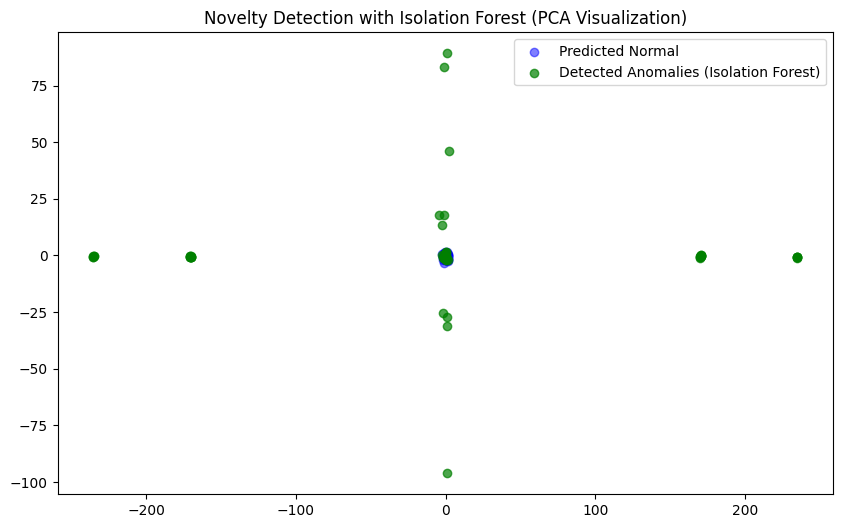

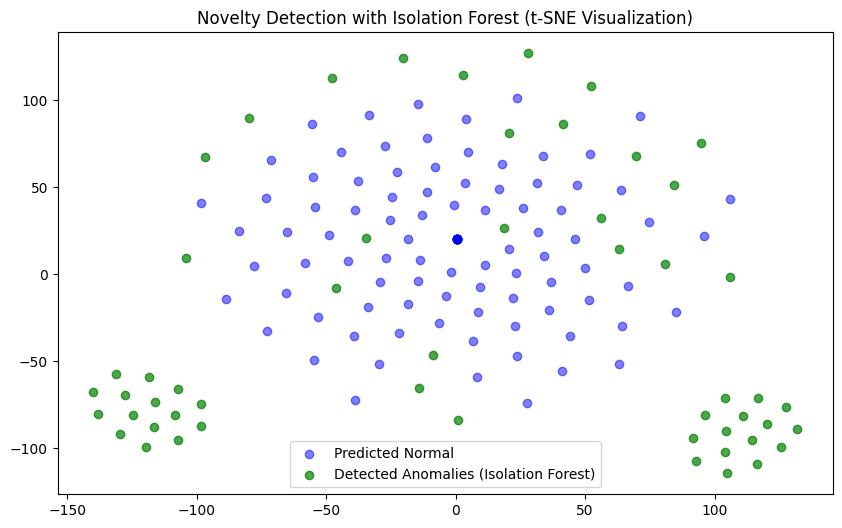

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Assuming X_test_mixed is your dataset
print("Available features:", X_test_mixed.columns)

# Select all features except 'flag' and 'total_consumption'
feature_columns = [col for col in X_test_mixed.columns if col not in ['FLAG', 'total_consumption']]
print("Selected features for analysis:", feature_columns)

# Generate synthetic normal and new data
np.random.seed(42)
normal_data = pd.DataFrame(np.random.randn(200, len(feature_columns)), columns=feature_columns)
new_data = pd.DataFrame(np.random.randn(100, len(feature_columns)), columns=feature_columns)

# Scale the normal data
scaler = StandardScaler()
normal_data_scaled = scaler.fit_transform(normal_data)

# **Parameter Tuning for Isolation Forest**
param_grid_iso = {'contamination': [0.05, 0.1, 0.15], 'n_estimators': [100, 150, 200]}
grid_search_iso = GridSearchCV(IsolationForest(random_state=42), param_grid_iso, scoring='accuracy', cv=3)
grid_search_iso.fit(normal_data_scaled)

# Best Isolation Forest model
iso_forest = grid_search_iso.best_estimator_
print("Best parameters for Isolation Forest:", grid_search_iso.best_params_)

# Scale the new data for prediction
new_data_scaled = scaler.transform(new_data)

# Create standard novelty behaviors (min, max, and mean deviations)
min_values = normal_data_scaled.min(axis=0) - 3
max_values = normal_data_scaled.max(axis=0) + 3
mean_values = normal_data_scaled.mean(axis=0)

# Generate synthetic anomalies based on these standard novelties
anomalies = pd.DataFrame(
    np.vstack([
        np.random.uniform(low=min_values, high=min_values + 1, size=(10, len(feature_columns))),  # Min-based
        np.random.uniform(low=max_values - 1, high=max_values, size=(10, len(feature_columns))),  # Max-based
        np.tile(mean_values, (10, 1))  # Mean-based
    ]),
    columns=feature_columns
)

# Scale anomalies for consistency
anomalies_scaled = scaler.transform(anomalies)

# **Generate New Unseen Novelty Types**
extreme_low_values = normal_data_scaled.min(axis=0) - 5
extreme_high_values = normal_data_scaled.max(axis=0) + 5
noise_values = np.random.normal(0, 5, size=(10, len(feature_columns)))  # Random noise with high variance

# Create new synthetic anomalies with these extreme behaviors
new_novelties = pd.DataFrame(
    np.vstack([
        np.random.uniform(low=extreme_low_values, high=extreme_low_values + 1, size=(5, len(feature_columns))),  # Extreme low
        np.random.uniform(low=extreme_high_values - 1, high=extreme_high_values, size=(5, len(feature_columns))),  # Extreme high
        noise_values  # Random noise
    ]),
    columns=feature_columns
)

# Scale the new novelties for consistency
new_novelties_scaled = scaler.transform(new_novelties)

# Combine all data
combined_data_scaled = np.vstack((new_data_scaled, anomalies_scaled, new_novelties_scaled))
combined_data = pd.concat([new_data, anomalies, new_novelties], ignore_index=True)

# Predict novelties using Isolation Forest
iso_predictions = iso_forest.predict(combined_data_scaled)
iso_predictions = np.where(iso_predictions == 1, 0, 1)  # Convert to 0 for normal, 1 for anomaly

# Evaluate Model Performance
true_labels = np.concatenate((np.zeros(len(new_data)), np.ones(len(anomalies) + len(new_novelties))))

print("Evaluation for Isolation Forest:")
print("Classification Report:\n", classification_report(true_labels, iso_predictions, target_names=["Normal", "Anomaly"]))
print("Confusion Matrix:\n", confusion_matrix(true_labels, iso_predictions))

# **Dimensionality Reduction for Visualization**
# Using PCA to reduce dimensions to 2 for plotting
pca = PCA(n_components=2)
combined_data_pca = pca.fit_transform(combined_data_scaled)

plt.figure(figsize=(10, 6))
plt.scatter(combined_data_pca[iso_predictions == 0, 0], combined_data_pca[iso_predictions == 0, 1], color='blue', label='Predicted Normal', alpha=0.5)
plt.scatter(combined_data_pca[iso_predictions == 1, 0], combined_data_pca[iso_predictions == 1, 1], color='green', label='Detected Anomalies (Isolation Forest)', alpha=0.7)
plt.title("Novelty Detection with Isolation Forest (PCA Visualization)")
plt.legend()
plt.show()

# Using t-SNE for dimensionality reduction and visualization
tsne = TSNE(n_components=2, random_state=42)
combined_data_tsne = tsne.fit_transform(combined_data_scaled)

plt.figure(figsize=(10, 6))
plt.scatter(combined_data_tsne[iso_predictions == 0, 0], combined_data_tsne[iso_predictions == 0, 1], color='blue', label='Predicted Normal', alpha=0.5)
plt.scatter(combined_data_tsne[iso_predictions == 1, 0], combined_data_tsne[iso_predictions == 1, 1], color='green', label='Detected Anomalies (Isolation Forest)', alpha=0.7)
plt.title("Novelty Detection with Isolation Forest (t-SNE Visualization)")
plt.legend()
plt.show()

<ipython-input-27-aea57d6fcc28>:47: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  combined_data.fillna(method='bfill', inplace=True)
<ipython-input-27-aea57d6fcc28>:56: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_data.fillna(method='bfill', inplace=True)


Novelty Detection Evaluation:
Classification Report:
               precision    recall  f1-score   support

      Normal       0.97      0.90      0.93       200
     Novelty       0.69      0.88      0.77        50

    accuracy                           0.90       250
   macro avg       0.83      0.89      0.85       250
weighted avg       0.91      0.90      0.90       250

Confusion Matrix:
 [[180  20]
 [  6  44]]


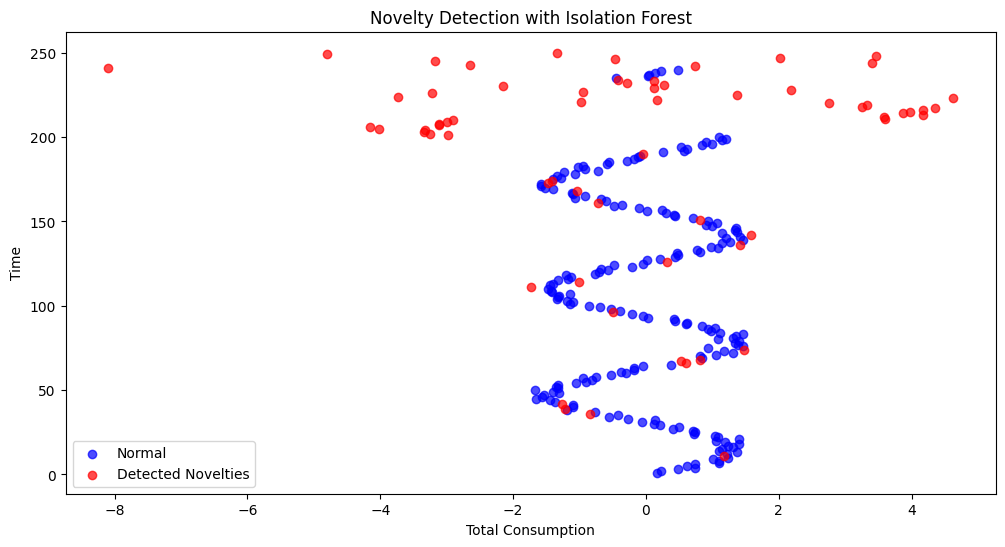

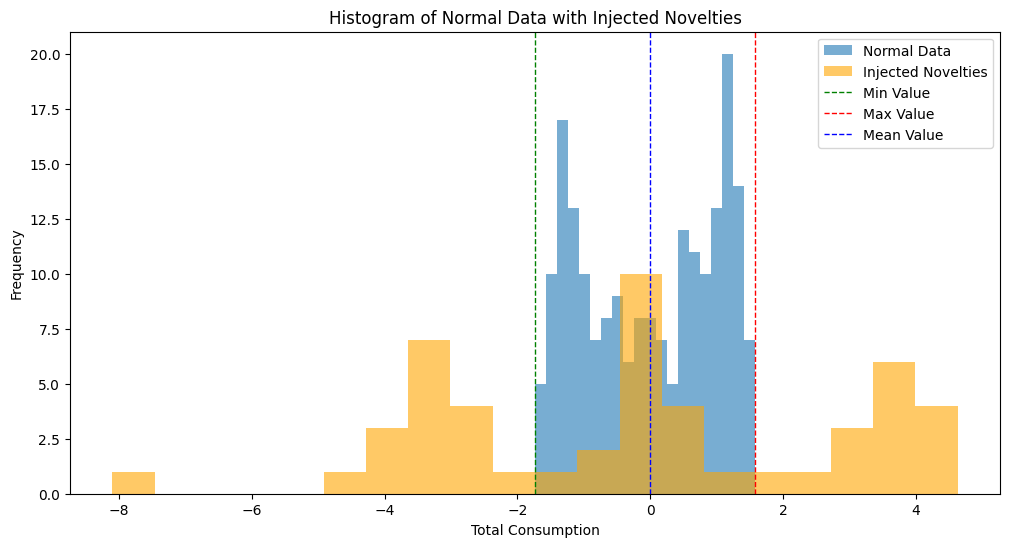

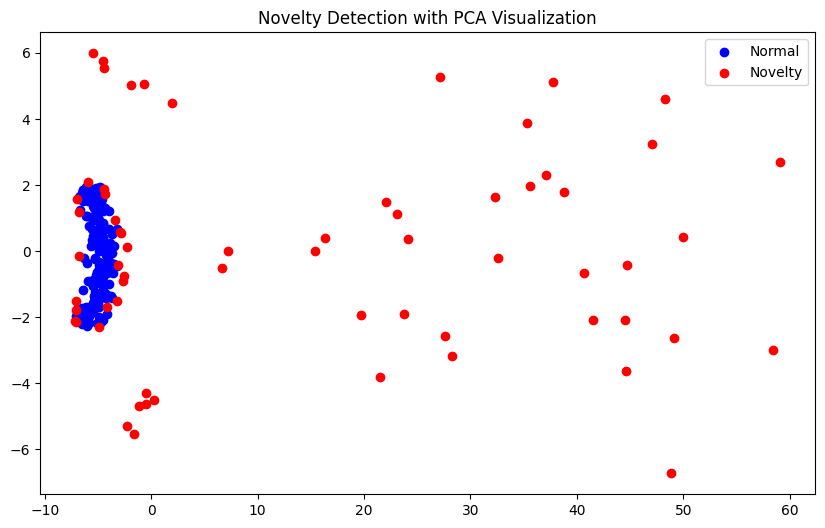

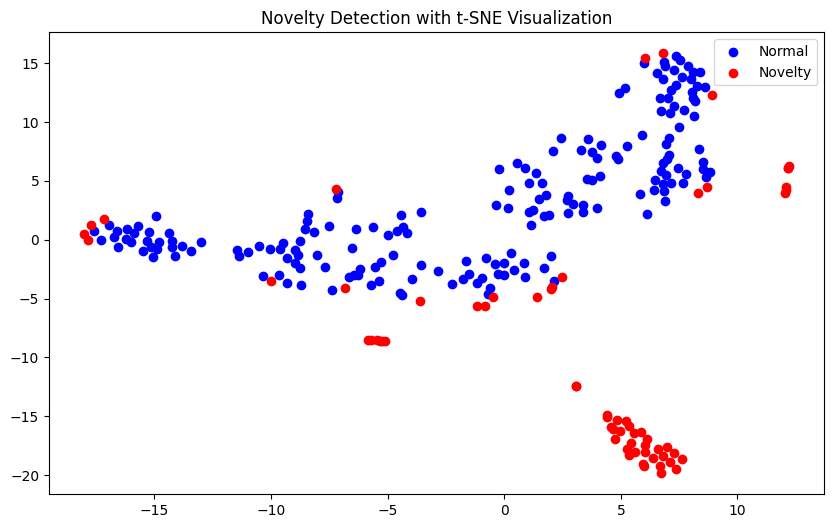

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.stats import norm

# Simulated normal dataset
np.random.seed(42)
time = np.linspace(1, 200, 200)  # Time feature (x-axis)
total_consumption = np.sin(time / 10) + np.random.normal(0, 0.1, size=200)  # Total consumption (y-axis)

# Fit data to normal distribution
mu, sigma = norm.fit(total_consumption)  # Mean and standard deviation of normal data
total_consumption_normalized = (total_consumption - mu) / sigma  # Normalize to standard normal distribution

# Create normal data DataFrame
df = pd.DataFrame({'time': time, 'total_consumption': total_consumption_normalized})

# **Inject Novel Behaviors**
novel_time = np.linspace(201, 250, 50)

# Define novel behaviors (unseen during training)
min_value = df['total_consumption'].min()
max_value = df['total_consumption'].max()
mean_value = df['total_consumption'].mean()

novel_consumption = np.concatenate([
    np.random.uniform(min_value - 3, min_value - 1, 10),  # Extreme low values
    np.random.uniform(max_value + 1, max_value + 3, 10),  # Extreme high values
    np.random.normal(mean_value, 2, 10),  # High variance
    np.random.uniform(mean_value - 0.5, mean_value + 0.5, 10),  # Noise near mean
    np.random.normal(0, 4, 10)  # Random noise
])

novel_data = pd.DataFrame({'time': novel_time, 'total_consumption': novel_consumption})

# Combine original and novel data for testing
combined_data = pd.concat([df, novel_data], ignore_index=True)

# Feature engineering: Add rolling mean and standard deviation
combined_data['rolling_mean'] = combined_data['total_consumption'].rolling(window=5).mean()
combined_data['rolling_std'] = combined_data['total_consumption'].rolling(window=5).std()
combined_data.fillna(method='bfill', inplace=True)

# Select features for analysis
features = ['total_consumption', 'rolling_mean', 'rolling_std']

# Split normal data for training and use entire data for testing
train_data = df.copy()
train_data['rolling_mean'] = train_data['total_consumption'].rolling(window=5).mean()
train_data['rolling_std'] = train_data['total_consumption'].rolling(window=5).std()
train_data.fillna(method='bfill', inplace=True)

# Scaling
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_data[features])
test_scaled = scaler.transform(combined_data[features])

# Train Isolation Forest
iso_forest = IsolationForest(n_estimators=200, contamination=0.1, random_state=42)
iso_forest.fit(train_scaled)  # Train on normal data

# Predict novelties
combined_data['novelty'] = iso_forest.predict(test_scaled)
combined_data['novelty'] = np.where(combined_data['novelty'] == 1, 0, 1)  # 1 for novelty, 0 for normal

# True labels for evaluation
true_labels = np.concatenate((np.zeros(len(df)), np.ones(len(novel_data))))

# Evaluation
print("Novelty Detection Evaluation:")
print("Classification Report:\n", classification_report(true_labels, combined_data['novelty'], target_names=["Normal", "Novelty"]))
print("Confusion Matrix:\n", confusion_matrix(true_labels, combined_data['novelty']))

# **Visualization**
# Total Consumption (x-axis) vs. Time (y-axis) with detected novelties
plt.figure(figsize=(12, 6))
plt.scatter(combined_data['total_consumption'][combined_data['novelty'] == 0],
            combined_data['time'][combined_data['novelty'] == 0],
            color='blue', label='Normal', alpha=0.7)
plt.scatter(combined_data['total_consumption'][combined_data['novelty'] == 1],
            combined_data['time'][combined_data['novelty'] == 1],
            color='red', label='Detected Novelties', alpha=0.7)
plt.title('Novelty Detection with Isolation Forest')
plt.xlabel('Total Consumption')
plt.ylabel('Time')
plt.legend()
plt.show()

# **Histogram of Normal Data and Injected Novelties**
plt.figure(figsize=(12, 6))
plt.hist(df['total_consumption'], bins=20, alpha=0.6, label='Normal Data')
plt.hist(novel_data['total_consumption'], bins=20, alpha=0.6, label='Injected Novelties', color='orange')
plt.axvline(min_value, color='green', linestyle='dashed', linewidth=1, label='Min Value')
plt.axvline(max_value, color='red', linestyle='dashed', linewidth=1, label='Max Value')
plt.axvline(mean_value, color='blue', linestyle='dashed', linewidth=1, label='Mean Value')
plt.title('Histogram of Normal Data with Injected Novelties')
plt.xlabel('Total Consumption')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# **Dimensionality Reduction for Visualization**
# PCA visualization
pca = PCA(n_components=2)
pca_data = pca.fit_transform(test_scaled)

plt.figure(figsize=(10, 6))
plt.scatter(pca_data[combined_data['novelty'] == 0, 0], pca_data[combined_data['novelty'] == 0, 1], color='blue', label='Normal')
plt.scatter(pca_data[combined_data['novelty'] == 1, 0], pca_data[combined_data['novelty'] == 1, 1], color='red', label='Novelty')
plt.title("Novelty Detection with PCA Visualization")
plt.legend()
plt.show()

# t-SNE visualization
tsne = TSNE(n_components=2, random_state=42)
tsne_data = tsne.fit_transform(test_scaled)

plt.figure(figsize=(10, 6))
plt.scatter(tsne_data[combined_data['novelty'] == 0, 0], tsne_data[combined_data['novelty'] == 0, 1], color='blue', label='Normal')
plt.scatter(tsne_data[combined_data['novelty'] == 1, 0], tsne_data[combined_data['novelty'] == 1, 1], color='red', label='Novelty')
plt.title("Novelty Detection with t-SNE Visualization")
plt.legend()
plt.show()


In [ ]:
data = pd.DataFrame({
    'time': np.arange(1, 101),  # Simulated time data
    'total_consumption': np.random.uniform(10, 100, 100),  # Random consumption values
    'flag': np.random.choice([0, 1], size=100, p=[0.8, 0.2])  # Random flags (80% train, 20% test)
})

In [ ]:
print(data.columns)


Index(['time', 'total_consumption', 'flag'], dtype='object')


In [ ]:
data.rename(columns={'your_time_column': 'time',
                     'your_consumption_column': 'total_consumption',
                     'your_flag_column': 'flag'}, inplace=True)


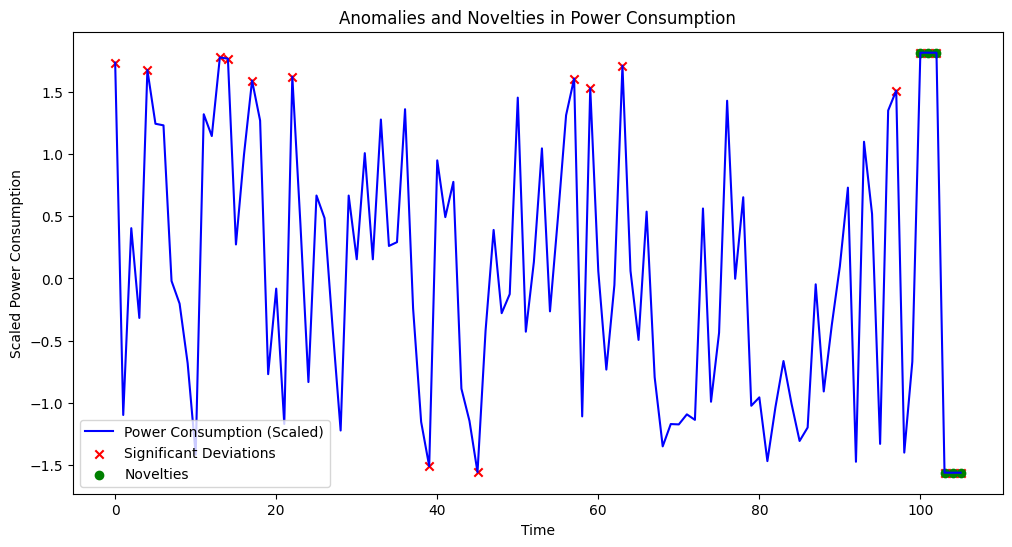

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Mock dataset
data = pd.DataFrame({
    'time': np.arange(1, 101),
    'total_consumption': np.random.uniform(10, 100, 100),
    'flag': np.random.choice([0, 1], size=100, p=[0.8, 0.2])
})

# Validate input dataset
if not all(col in data.columns for col in ['time', 'total_consumption', 'flag']):
    raise ValueError("Dataset must include 'time', 'total_consumption', and 'flag' columns.")

# Split dataset based on flag
train_data = data[data['flag'] == 0]
test_data = data[data['flag'].isin([0, 1])]

# Extract features
train_time = train_data['time'].values
train_consumption = train_data['total_consumption'].values
test_time = test_data['time'].values
test_consumption = test_data['total_consumption'].values

# Combine features into matrices
X_train = np.column_stack((train_time, train_consumption))
X_test = np.column_stack((test_time, test_consumption))

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train LOF on training data (flag=0)
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
lof_labels_train = lof.fit_predict(X_train_scaled)  # -1 indicates anomaly

# Test LOF on test data (flag=0 and flag=1)
lof_labels_test = lof.fit_predict(X_test_scaled)  # -1 indicates anomaly
test_anomalies = X_test_scaled[lof_labels_test == -1]

# Introduce novelty data (flag=-1)
novelty_time = np.linspace(max(test_time) + 1, max(test_time) + 6, 6)  # 6 new timestamps
novelty_consumption = np.concatenate((
    test_consumption.max() + (test_consumption.max() * 0.01) * np.ones(3),  # 3 above max
    test_consumption.min() - (test_consumption.min() * 0.01) * np.ones(3)   # 3 below min
))
novelty_data = np.column_stack((novelty_time, novelty_consumption))
novelty_data_scaled = scaler.transform(novelty_data)

# Combine test data and novelties
combined_test_data = np.vstack((X_test_scaled, novelty_data_scaled))

# Perform K-means clustering on detected anomalies and novelties
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
combined_labels = kmeans.fit_predict(combined_test_data)

# Detect significant deviations
median_consumption = np.median(combined_test_data[:, 1])
deviation_threshold = 1.5
significant_deviations = combined_test_data[
    np.abs(combined_test_data[:, 1] - median_consumption) > deviation_threshold
]

# Visualization
time_combined = np.arange(len(combined_test_data))  # Time for combined data
zoom_range = 200  # Visualization range

plt.figure(figsize=(12, 6))
plt.plot(time_combined[:zoom_range], combined_test_data[:zoom_range, 1], label='Power Consumption (Scaled)', color='blue')

# Mark significant deviations
significant_indexes = np.abs(combined_test_data[:, 1] - median_consumption) > deviation_threshold
plt.scatter(
    time_combined[significant_indexes],
    combined_test_data[significant_indexes, 1],
    color='red',
    label='Significant Deviations',
    marker='x'
)

# Mark novelties
novelty_indexes = np.arange(len(X_test_scaled), len(combined_test_data))
plt.scatter(
    time_combined[novelty_indexes],
    combined_test_data[novelty_indexes, 1],
    color='green',
    label='Novelties',
    marker='o'
)

plt.xlabel('Time')
plt.ylabel('Scaled Power Consumption')
plt.title('Anomalies and Novelties in Power Consumption')
plt.legend()
plt.show()



Explanation for above code-:
Synthetic data was created to simulate novelty by generating new time points beyond the existing dataset and assigning power consumption values outside the observed range, slightly above the maximum and below the minimum. This novelty data was then scaled to match the feature space and combined with the test data. K-Means clustering was applied to this combined data, where large deviations from the median were identified. Visualization emphasized novelties and deviations, which allowed for robust anomaly detection and tested the capability of the model to identify unusual patterns not seen previously.

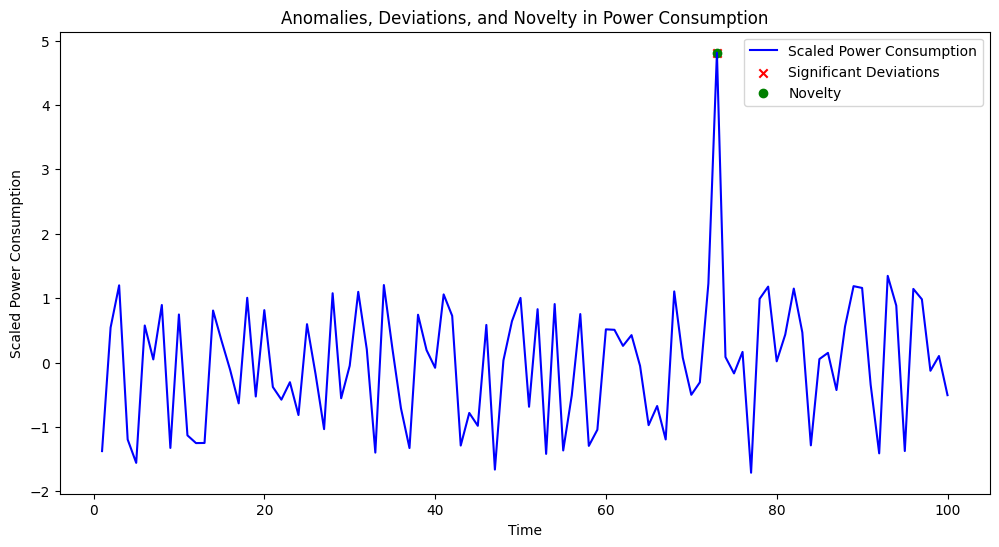

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler

# Mock dataset with a single novelty introduced
data = pd.DataFrame({
    'time': np.arange(1, 101),
    'total_consumption': np.random.uniform(10, 100, 100),
    'flag': np.zeros(100, dtype=int)  # Initial dataset without anomalies
})

# Introduce a single novelty in the data
novelty_index = np.random.randint(0, 100)  # Random index for novelty
data.loc[novelty_index, 'total_consumption'] = data['total_consumption'].max() * 2  # Extreme value for novelty
data.loc[novelty_index, 'flag'] = -1  # Mark novelty with a unique flag

# Extract features
time = data['time'].values
consumption = data['total_consumption'].values
flags = data['flag'].values

# Scale features
scaler = StandardScaler()
scaled_consumption = scaler.fit_transform(consumption.reshape(-1, 1)).flatten()

# Apply Local Outlier Factor for anomaly detection
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
lof_labels = lof.fit_predict(scaled_consumption.reshape(-1, 1))  # -1 indicates anomaly

# Detect significant deviations based on standard deviation
mean_consumption = scaled_consumption.mean()
std_dev_consumption = scaled_consumption.std()
deviation_threshold = 3 * std_dev_consumption  # Threshold for significant deviation
significant_deviation = np.abs(scaled_consumption - mean_consumption) > deviation_threshold

# Visualize the data, anomalies, and the novelty
plt.figure(figsize=(12, 6))
plt.plot(time, scaled_consumption, label='Scaled Power Consumption', color='blue')

# Mark significant deviations
plt.scatter(
    time[significant_deviation],
    scaled_consumption[significant_deviation],
    color='red',
    label='Significant Deviations',
    marker='x'
)

# Mark the novelty
novelty_points = data[data['flag'] == -1]
plt.scatter(
    novelty_points['time'],
    scaler.transform(novelty_points['total_consumption'].values.reshape(-1, 1)),
    color='green',
    label='Novelty',
    marker='o'
)

plt.xlabel('Time')
plt.ylabel('Scaled Power Consumption')
plt.title('Anomalies, Deviations, and Novelty in Power Consumption')
plt.legend()
plt.show()
